In [9]:
!pip install rasterio --quiet

In [3]:
# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')



# --- Import Required Packages ---
import os
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# --- Define Paths ---
BASE_DIR = "/content/drive/MyDrive/Environmental/"
LANDCOVER_DIR = os.path.join(BASE_DIR, "landcover_images/")
CLEANED_DIR = os.path.join(BASE_DIR, "cleaned_data/landcover/")

# Create cleaned directory if not exists
os.makedirs(CLEANED_DIR, exist_ok=True)

In [11]:
# --- List all Land Cover files ---
landcover_files = sorted([os.path.join(LANDCOVER_DIR, f) for f in os.listdir(LANDCOVER_DIR) if f.endswith('.tif')])
print(f"✅ Found {len(landcover_files)} land cover files.")

✅ Found 8 land cover files.


In [12]:
# --- Initialize Storage ---
metadata_list = []
area_stats_list = []

# --- Read and Process Each Raster ---
for lc_file in landcover_files:
    year = os.path.basename(lc_file).split('_')[1][:4]  # Extract year from filename like 45R_201701.tif

    with rasterio.open(lc_file) as src:
        print(f"📂 Processing {os.path.basename(lc_file)}")

        # Check basic metadata
        meta = src.meta
        bounds = src.bounds
        crs = src.crs
        res = src.res

        metadata_list.append({
            'Year': int(year),
            'Filename': os.path.basename(lc_file),
            'CRS': crs.to_string(),
            'Resolution_X': res[0],
            'Resolution_Y': res[1],
            'Width': src.width,
            'Height': src.height,
            'Bounds': bounds
        })

        # Read raster
        raster = src.read(1)

        # Count pixels per land cover class
        unique, counts = np.unique(raster, return_counts=True)
        total_pixels = raster.size
        pixel_area_km2 = abs(res[0] * res[1]) / 1e6  # Convert from m² to km²

        for u, c in zip(unique, counts):
            area_stats_list.append({
                'Year': int(year),
                'Class': int(u),
                'Pixel_Count': int(c),
                'Area_km2': round(c * pixel_area_km2, 3),
                'Percent_of_Image': round(100 * (c / total_pixels), 2)
            })

print(f"✅ Finished processing all land cover rasters.")

📂 Processing 45R_20170101-20180101.tif
📂 Processing 45R_20180101-20190101.tif
📂 Processing 45R_20190101-20200101.tif
📂 Processing 45R_20200101-20210101.tif
📂 Processing 45R_20210101-20220101.tif
📂 Processing 45R_20220101-20230101.tif
📂 Processing 45R_20230101-20240101.tif
📂 Processing 45R_20240101-20241231.tif
✅ Finished processing all land cover rasters.


✅ Saved metadata summary: /content/drive/MyDrive/Environmental/cleaned_data/landcover/landcover_metadata_summary.csv
✅ Saved area statistics summary: /content/drive/MyDrive/Environmental/cleaned_data/landcover/landcover_area_stats.csv


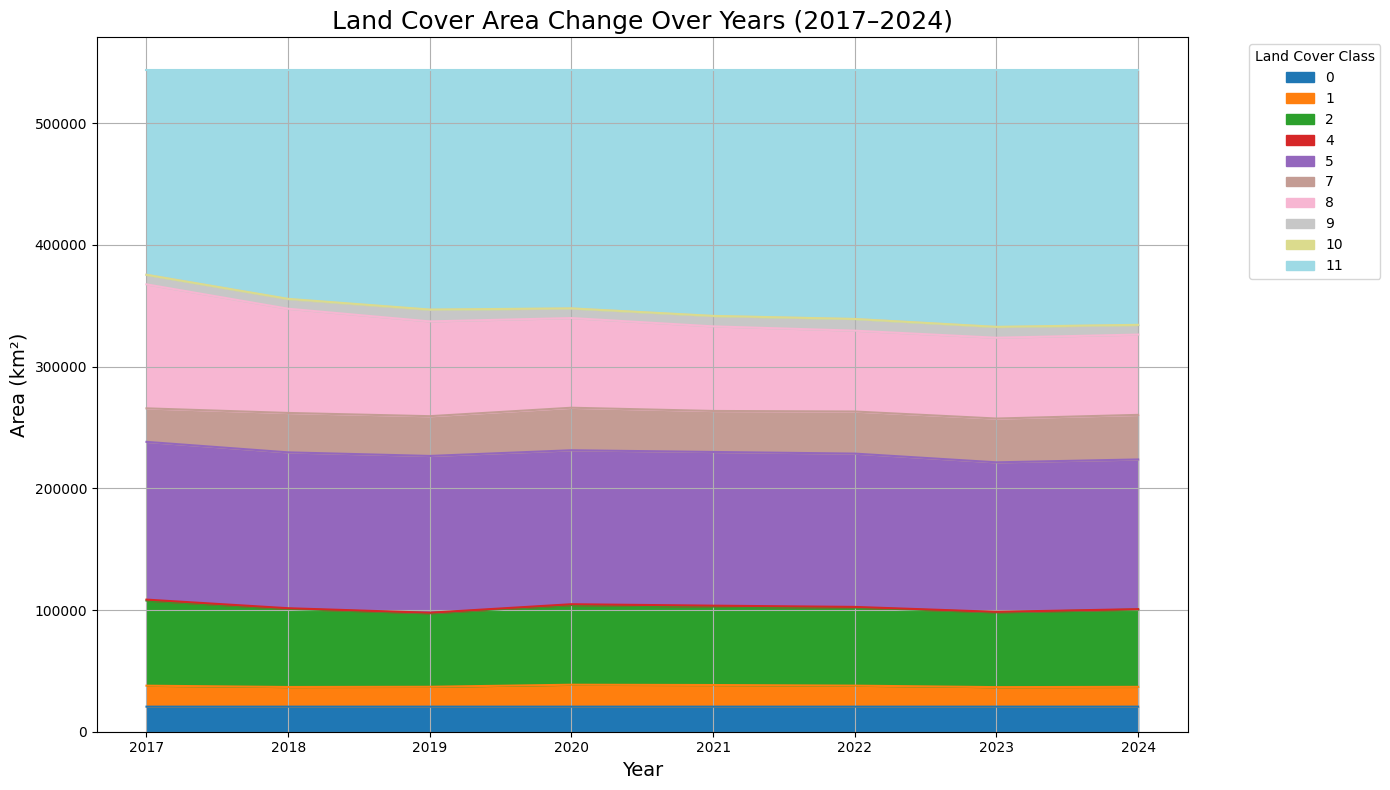

In [13]:
# --- Save Metadata Summary ---
df_metadata = pd.DataFrame(metadata_list)
metadata_csv = os.path.join(CLEANED_DIR, "landcover_metadata_summary.csv")
df_metadata.to_csv(metadata_csv, index=False)
print(f"✅ Saved metadata summary: {metadata_csv}")

# --- Save Area Statistics Summary ---
df_area_stats = pd.DataFrame(area_stats_list)
area_stats_csv = os.path.join(CLEANED_DIR, "landcover_area_stats.csv")
df_area_stats.to_csv(area_stats_csv, index=False)
print(f"✅ Saved area statistics summary: {area_stats_csv}")

# --- Quick Visual Preview: Area per Class per Year ---

pivot_area = df_area_stats.pivot(index='Year', columns='Class', values='Area_km2')

pivot_area.plot(kind='area', stacked=True, figsize=(14, 8), colormap='tab20')
plt.title('Land Cover Area Change Over Years (2017–2024)', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Area (km²)', fontsize=14)
plt.grid(True)
plt.legend(title='Land Cover Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [4]:
!pip install rasterio matplotlib --quiet

In [6]:
# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')



# --- Import Packages ---
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import gc  # Garbage collector

# --- Set Base Directory ---
BASE_DIR = "/content/drive/MyDrive/Environmental/"
LANDCOVER_DIR = os.path.join(BASE_DIR, "landcover_images/")
PREVIEW_DIR = os.path.join(BASE_DIR, "landcover_images_previews/")

# Create preview folder if not exist
os.makedirs(PREVIEW_DIR, exist_ok=True)

# --- List all .tif files ---
landcover_files = sorted([os.path.join(LANDCOVER_DIR, f) for f in os.listdir(LANDCOVER_DIR) if f.endswith('.tif')])
print(f"✅ Found {len(landcover_files)} land cover raster files.")

# --- Read and Save Each Raster (RAM-Friendly) ---
for lc_file in landcover_files:
    year = os.path.basename(lc_file).split('_')[1][:4]

    with rasterio.open(lc_file) as src:
        # Read only every 5th pixel to downscale and save memory
        raster = src.read(
            1,
            out_shape=(
                int(src.height // 5),
                int(src.width // 5)
            ),
            resampling=rasterio.enums.Resampling.nearest
        )

    # Normalize raster for visualization
    raster_preview = np.clip(raster, 0, np.max(raster))

    # Save PNG
    plt.figure(figsize=(6, 5))
    plt.imshow(raster_preview, cmap='tab20')
    plt.title(f"Land Cover {year}", fontsize=14)
    plt.axis('off')

    preview_path = os.path.join(PREVIEW_DIR, f"landcover_{year}.png")
    plt.savefig(preview_path, bbox_inches='tight', pad_inches=0.1, dpi=100)
    plt.close('all')  # Force close plot to free memory
    gc.collect()      # Explicitly clean garbage

    print(f"✅ Saved preview image for {year}: {preview_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Found 8 land cover raster files.
✅ Saved preview image for 2017: /content/drive/MyDrive/Environmental/landcover_images_previews/landcover_2017.png
✅ Saved preview image for 2018: /content/drive/MyDrive/Environmental/landcover_images_previews/landcover_2018.png
✅ Saved preview image for 2019: /content/drive/MyDrive/Environmental/landcover_images_previews/landcover_2019.png
✅ Saved preview image for 2020: /content/drive/MyDrive/Environmental/landcover_images_previews/landcover_2020.png
✅ Saved preview image for 2021: /content/drive/MyDrive/Environmental/landcover_images_previews/landcover_2021.png
✅ Saved preview image for 2022: /content/drive/MyDrive/Environmental/landcover_images_previews/landcover_2022.png
✅ Saved preview image for 2023: /content/drive/MyDrive/Environmental/landcover_images_previews/landcover_2023.png
✅ Saved preview image for 2024: /conte

In [7]:
!pip install pillow --quiet

In [8]:


# --- Import Required Libraries ---
import os
from PIL import Image

# --- Define Paths ---
BASE_DIR = "/content/drive/MyDrive/Environmental/"
PREVIEW_DIR = os.path.join(BASE_DIR, "landcover_images_previews/")
GIF_OUTPUT_PATH = os.path.join(PREVIEW_DIR, "landcover_change_animation.gif")

# --- List All PNG Preview Files ---
png_files = sorted([os.path.join(PREVIEW_DIR, f) for f in os.listdir(PREVIEW_DIR) if f.endswith('.png')])

print(f"✅ Found {len(png_files)} PNG preview images.")

# --- Load Images into a List ---
frames = [Image.open(png) for png in png_files]

# --- Create and Save GIF ---
frames[0].save(
    GIF_OUTPUT_PATH,
    format='GIF',
    append_images=frames[1:],
    save_all=True,
    duration=800,  # Duration per frame in ms (800ms = 0.8s)
    loop=0
)

print(f"✅ Land Cover GIF created successfully at: {GIF_OUTPUT_PATH}")


✅ Found 8 PNG preview images.
✅ Land Cover GIF created successfully at: /content/drive/MyDrive/Environmental/landcover_images_previews/landcover_change_animation.gif


# forest cover

In [15]:
import pandas as pd
import os

# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Import Required Packages ---
import pandas as pd
import os

# --- Define Paths ---
BASE_DIR = "/content/drive/MyDrive/Environmental/"
FOREST_DIR = os.path.join(BASE_DIR, "forest_cover/")
LANDCOVER_CLEANED_DIR = os.path.join(BASE_DIR, "cleaned_data/landcover/")

os.makedirs(FOREST_DIR, exist_ok=True)

# --- Load All Datasets ---
tropical_csv_path = os.path.join(FOREST_DIR, "Tropical_Tree_Cover.csv")
loss_csv_path = os.path.join(FOREST_DIR, "treecover_loss__ha.csv")
landcover_csv_path = os.path.join(LANDCOVER_CLEANED_DIR, "landcover_area_stats.csv")

df_tropical = pd.read_csv(tropical_csv_path)
df_loss = pd.read_csv(loss_csv_path)
df_landcover = pd.read_csv(landcover_csv_path)

print(" Datasets Loaded Successfully!")
print("\n Tropical Tree Cover Preview:")
print(df_tropical.head())

print("\n Tree Cover Loss Preview:")
print(df_loss.head())

print("\n Land Cover Stats Preview:")
print(df_landcover.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Datasets Loaded Successfully!

 Tropical Tree Cover Preview:
    tile_id                              half_hectare_download  \
0  00N_000E  https://data-api.globalforestwatch.org/dataset...   
1  00N_010E  https://data-api.globalforestwatch.org/dataset...   
2  00N_020E  https://data-api.globalforestwatch.org/dataset...   
3  00N_030E  https://data-api.globalforestwatch.org/dataset...   
4  00N_040E  https://data-api.globalforestwatch.org/dataset...   

                                       F10m_download  ObjectId   Shape__Area  \
0  https://data-api.globalforestwatch.org/dataset...         1  1.245543e+12   
1  https://data-api.globalforestwatch.org/dataset...         2  1.245543e+12   
2  https://data-api.globalforestwatch.org/dataset...         3  1.245543e+12   
3  https://data-api.globalforestwatch.org/dataset...         4  1.245543e+12   
4  https://d

In [16]:
print("\n Tropical Columns:", df_tropical.columns.tolist())
print("\n Loss Columns:", df_loss.columns.tolist())
print("\n Landcover Columns:", df_landcover.columns.tolist())



 Tropical Columns: ['tile_id', 'half_hectare_download', 'F10m_download', 'ObjectId', 'Shape__Area', 'Shape__Length']

 Loss Columns: ['iso', 'umd_tree_cover_loss__year', 'umd_tree_cover_loss__ha', 'gfw_gross_emissions_co2e_all_gases__Mg']

 Landcover Columns: ['Year', 'Class', 'Pixel_Count', 'Area_km2', 'Percent_of_Image']


In [20]:
# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Import Packages ---
import pandas as pd
import os

# --- Define Paths ---
BASE_DIR = "/content/drive/MyDrive/Environmental/"
FOREST_DIR = os.path.join(BASE_DIR, "forest_cover/")
LANDCOVER_CLEANED_DIR = os.path.join(BASE_DIR, "cleaned_data/landcover/")
COMBINED_DIR = os.path.join(BASE_DIR, "cleaned_data/combined/")
os.makedirs(COMBINED_DIR, exist_ok=True)

# --- Load Datasets ---
loss_csv_path = os.path.join(FOREST_DIR, "treecover_loss__ha.csv")
landcover_csv_path = os.path.join(LANDCOVER_CLEANED_DIR, "landcover_area_stats.csv")

df_loss = pd.read_csv(loss_csv_path)
df_landcover = pd.read_csv(landcover_csv_path)

print(" Loaded datasets!")

# --- Clean Forest Cover Loss Data ---
df_forest_loss_cleaned = df_loss[df_loss['iso'] == 'NPL'][['umd_tree_cover_loss__year', 'umd_tree_cover_loss__ha']]
df_forest_loss_cleaned = df_forest_loss_cleaned.rename(columns={
    'umd_tree_cover_loss__year': 'Year',
    'umd_tree_cover_loss__ha': 'Forest_Loss_ha'
})

print("\n Cleaned Forest Loss Data:")
print(df_forest_loss_cleaned.head())

# --- Clean Land Cover Data (Class 2 = Forest) ---
df_landcover_forest = df_landcover[df_landcover['Class'] == 2][['Year', 'Area_km2']]
df_landcover_forest = df_landcover_forest.rename(columns={'Area_km2': 'Forest_Area_LandCover_km2'})

print("\n Cleaned Land Cover Data (only Forest Class):")
print(df_landcover_forest.head())

# --- Merge on Year ---
df_combined = pd.merge(df_forest_loss_cleaned, df_landcover_forest, on='Year', how='inner')

print("\n Merged Combined Dataset:")
print(df_combined.head())

# --- Save Final Combined Dataset ---
combined_output_path = os.path.join(COMBINED_DIR, "land_forest_combined_features.csv")
df_combined.to_csv(combined_output_path, index=False)

print(f"\n Final Combined Dataset saved at: {combined_output_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Loaded datasets!

 Cleaned Forest Loss Data:
   Year  Forest_Loss_ha
0  2001     1523.194752
1  2002     2128.643310
2  2003     2291.937476
3  2004     2479.589152
4  2005     2758.319494

 Cleaned Land Cover Data (only Forest Class):
    Year  Forest_Area_LandCover_km2
2   2017                  69943.344
12  2018                  64183.301
22  2019                  60428.195
32  2020                  65478.815
42  2021                  64436.212

 Merged Combined Dataset:
   Year  Forest_Loss_ha  Forest_Area_LandCover_km2
0  2017     2394.083932                  69943.344
1  2018     1672.116611                  64183.301
2  2019     2087.028996                  60428.195
3  2020     2232.811564                  65478.815
4  2021     2752.510133                  64436.212

 Final Combined Dataset saved at: /content/drive/MyDrive/Environmental/cleaned_data/